In [1]:
import wandb
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys, os
if '../' not in sys.path:
    sys.path.append('..')
from source.rank_map import get_rank_map
from source.models import build_cp_layer, ResNet18Quant
from source.data import get_imagenet_test_loader, get_imagenet_train_val_loaders
from source.eval import accuracy
from source.layer_map import get_layer_list

import torch
from torchvision.models import resnet18

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
factor_name = os.path.join(f"../4bit_tensor_mseminmax_symmetric",
                           f"factors_admm_seed42",
                           f"layer1.0.conv1_admm_parafac-epc_rank_134_")
lossquanthist = torch.load(factor_name + 'lossquanthist.pt')
lossquanthist[-1]

0.21391701698303223

# prepare model for aimet

In [95]:
model_name = 'resnet18'
rate = 1.5
decomp = None
rank_map = get_rank_map(None, decomp, model_name, rate)
model = resnet18()
for module in ['layer1', 'layer2', 'layer3', 'layer4']:
        for layer_path in [f'{module}.0.conv1', f'{module}.0.conv2', 
                           f'{module}.1.conv1', f'{module}.1.conv2']:  

            lname, lidx, ltype = layer_path.split('.')
            lidx = int(lidx)
            layer = model.__getattr__(lname)[lidx].__getattr__(ltype)
            kernel_size = layer.kernel_size
            stride = layer.stride
            padding = layer.padding
            cin = layer.in_channels
            cout = layer.out_channels
            rank = rank_map[layer_path]
            bias = layer.bias
            groups = layer.groups
            if bias is not None: bias = bias.detach()

            model.__getattr__(lname)[lidx].__setattr__(
                    ltype, build_cp_layer(rank, [], bias, cin, cout, 
                                          kernel_size, padding, stride, groups).to(device))

model_name = f'{model_name}_m=parafac-epc_b=8_r={rate}_d={decomp}_i=random_s=42_tensor_mseminmax_symmetric_calibrated_4096'
state_dict = torch.load('../checkpoints/'+model_name).state_dict()
model.load_state_dict(state_dict)
torch.save(model, '../checkpoints_stas/'+model_name)

# getting ranks from wandb

In [3]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'admm-quantization'
api = wandb.Api()

columns = [
    'method',
    'model_name',
    'layer',
    'rank',
    'bits',
    'reduction_rate'
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished' and run.config.get('model_name') == 'regnet_y_3_2gf':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        i += 1
        
df.head()

  0%|          | 0/1473 [00:00<?, ?it/s]

,method,model_name,layer,rank,bits,reduction_rate
0,admm,regnet_y_3_2gf,trunk_output.block1.block1-0.f.b.0,99,4,1.5
1,admm,regnet_y_3_2gf,trunk_output.block1.block1-1.f.c.0,24,4,1.5
2,admm,regnet_y_3_2gf,trunk_output.block1.block1-1.f.se.fc2,9,4,1.5
3,admm,regnet_y_3_2gf,trunk_output.block1.block1-1.f.se.fc1,9,4,1.5
4,admm,regnet_y_3_2gf,trunk_output.block1.block1-1.f.b.0,98,4,1.5


In [21]:
# d = {}
# for rec in df[df.reduction_rate==1.5].sort_values('layer')[['layer', 'rank']].to_dict(orient='records'):
#     d[rec['layer']] = rec['rank']
# d

# check factors

In [4]:
method = 'admm'
qscheme = 'tensor_mseminmax_symmetric'
init = 'parafac-epc'
bits = 6
eps = None
# decomp = 'cp3-epc-pars'
decomp = None
rate = 3.0
seed=42
fused = False
rank_map = get_rank_map(eps, decomp, 'resnet18', rate)
layer_list = get_layer_list('resnet18', conv1=False, downsample=False)
num_samples = 10000
for layer_path in layer_list:
        rank = rank_map[layer_path]
        factor_name = os.path.join(f"../{bits}bit_{qscheme}",
                                   f"factors_{method}_seed{seed}" + ("_fused" if fused else ''), 
                                   f"{layer_path}_{method}_{init}_rank_{rank}_mode_")
#         print(factor_name)
        if not os.path.exists(factor_name+'0.pt'):
            print('missing', factor_name)

# ablation study init

In [43]:
method = 'admm'
qscheme = 'tensor_mseminmax_symmetric'
bits = 4
eps = None
rank = 1141
seed = 42
layer_path = 'layer4.0.conv2'

factor_name = os.path.join(f"../{bits}bit_{qscheme}",
                           f"factors_{method}_seed{seed}", 
                           f"{layer_path}_{method}_random_rank_{rank}_mode_")
factor_name = os.path.join(f"../{bits}bit_{qscheme}",
                           f"factors_{method}_seed{seed}", 
                           f"{layer_path}_{method}_random_rank_{rank}_mode_")

In [44]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'admm-quantization'
api = wandb.Api()

columns = [
    'qscheme',
    'bits',
    'seed',
    'rank',
    'quant_rec_error',
    'init',
    'createdAt',
    'epc_iter',
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished' and run.config['layer'] == 'layer4.0.conv2' and run.config['rank'] == 1141:
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run._attrs.get(col) is not None:
                df.loc[i][col] = run._attrs[col]
            elif run.history().get(col) is not None:
                df.loc[i][col] = run.history()[col]
            else:
                df.loc[i][col] = None
                
        i += 1
        
df.head()

  0%|          | 0/1473 [00:00<?, ?it/s]

,qscheme,bits,seed,rank,quant_rec_error,init,createdAt,epc_iter
0,tensor_affine,8,42,1141,"0 0.311873 Name: quant_rec_error, dtype: fl...",random,2023-03-03T12:03:00,None
1,tensor_affine,8,42,1141,"0 0.423223 Name: quant_rec_error, dtype: fl...",random,2023-03-03T07:15:39,None
2,tensor_mseminmax_symmetric,6,42,1141,0 0.478960 1 0.299545 2 0.295894 3...,parafac-epc,2023-02-28T12:00:52,None
3,tensor_mseminmax_symmetric,4,42,1141,0 0.459589 1 0.336002 2 0.323954 3...,parafac-epc,2023-02-28T09:19:50,None
4,tensor_mseminmax_symmetric,4,42,1141,0 0.656191 1 0.505957 2 0.46356...,random,2023-02-27T23:52:47,None


In [45]:
df_init = df \
[df.seed == 42] \
[df.bits == 4] \
[df.qscheme == 'tensor_mseminmax_symmetric'] \
[df['rank'] == 1141] \
.sort_values(['init','createdAt'])
df_init.iloc[1]['epc_iter'] = 100
df_init.iloc[0]['epc_iter'] = 50
df_init

/tmp/ipykernel_193680/4284101972.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_init = df \


,qscheme,bits,seed,rank,quant_rec_error,init,createdAt,epc_iter
5,tensor_mseminmax_symmetric,4,42,1141,0 0.498764 1 0.338714 2 0.326549 3...,parafac-epc,2023-02-27T11:44:13,50
3,tensor_mseminmax_symmetric,4,42,1141,0 0.459589 1 0.336002 2 0.323954 3...,parafac-epc,2023-02-28T09:19:50,100
4,tensor_mseminmax_symmetric,4,42,1141,0 0.656191 1 0.505957 2 0.46356...,random,2023-02-27T23:52:47,None


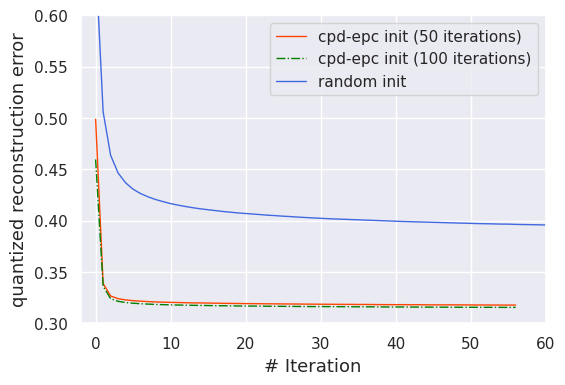

In [140]:
plt.figure(figsize=(6,4))

for _, row in df_init.iterrows():
    
    color = 'orangered'
    linestyle  = 'solid'
    if row.init == 'random':
        label = 'random init'
        color = 'royalblue'
    else:   
        label = f'cpd-epc init ({row.epc_iter} iterations)'
        if row.epc_iter == 100: 
            linestyle = 'dashdot'
            color = 'green'
        
    plt.plot(row.quant_rec_error, label=label, linestyle=linestyle, linewidth=1, color=color)
    
plt.xlim(-2, 60)
plt.ylim(0.3, 0.6)
plt.xlabel('# Iteration', fontsize=13)
plt.ylabel('quantized reconstruction error', fontsize=13)
plt.legend()
plt.savefig('init_ablation.png', bbox_inches='tight')
plt.show()

# ablation study qscheme

In [96]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'custom_benchmark'
api = wandb.Api()

columns = [
    'model_name',
    'model_path',
    'param_bw',
    'output_bw',
    'observer_samples',
    'param_qscheme',
    'output_qscheme',
    'reduction_rate',
    'bops',
    'macs',
    'acc1_calibrated',
    'acc5_calibrated',
    'acc1_wquantized',
    'acc5_wquantized',
    'acc1_aquantized',
    'acc5_aquantized',
    'seed',
    'bops%'
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif col == 'model_name' and run.name.startswith('resnet18'):
                df.loc[i][col] = 'resnet18'
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        if df.loc[i]['model_name'] == 'resnet18':
            df['bops%'] = df.bops/1819040768/32/32*100
        elif df.loc[i]['model_name'] == 'regnet_y_3_2gf':
            df['bops%'] = df.bops/2611094488/32/32*100
#         df['from_rate'] = 'None' in df.model_path
                
        i += 1
        
df.head()

  0%|          | 0/47 [00:00<?, ?it/s]

,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc5_calibrated,acc1_wquantized,acc5_wquantized,acc1_aquantized,acc5_aquantized,seed,bops%
0,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,8,500,tensor_mseminmax_symmetric,histogram,2,60511236736,945488074,0.685819,0.884263,0.684059,0.884143,0.679617,0.880842,42,3.248581
1,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,8,500,tensor_mseminmax_symmetric,histogram,2,60511236736,945488074,0.685819,0.884263,0.684059,0.884143,0.680578,0.882242,42,3.248581
2,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,8,500,tensor_mseminmax_symmetric,histogram,2,60511236736,945488074,0.685179,0.885063,0.682859,0.883583,0.679998,0.880882,42,3.248581
3,resnet18,checkpoints/resnet18_m=admm_b=6_r=2.0_d=cp3-ep...,6,8,500,tensor_mseminmax_symmetric,histogram,2,47667602912,945488074,0.680198,0.881702,0.678577,0.880922,0.675056,0.878561,42,2.559063
4,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.0_d=cp3-ep...,4,8,500,tensor_mseminmax_symmetric,histogram,2,34823969088,945488074,0.62664,0.845671,0.614977,0.839209,0.610015,0.834527,42,1.869545


In [103]:
custom_affine = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.output_qscheme == 'histogram'] \
[df.output_bw == 8] \
[df.model_path.str.contains("d=cp3-epc-pars")] \
[df.model_path.str.contains("m=admm")] \
[df.model_path.str.contains("tensor_affine")] \
.sort_values('acc1_aquantized')
custom_affine[['model_path', 'param_bw', 'acc1_calibrated', 'acc1_aquantized', 'bops%']]

/tmp/ipykernel_187247/1151626308.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_affine = df \


,model_path,param_bw,acc1_calibrated,acc1_aquantized,bops%
4,checkpoints/resnet18_m=admm_b=4_r=2.0_d=cp3-ep...,4,0.62664,0.610015,1.869545
3,checkpoints/resnet18_m=admm_b=6_r=2.0_d=cp3-ep...,6,0.680198,0.675056,2.559063
2,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,0.685179,0.679998,3.248581


In [102]:
custom_mse = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.output_qscheme == 'histogram'] \
[df.param_bw > 3] \
[df.output_bw == 8] \
[df.reduction_rate == 2.0] \
[df.model_path.str.contains("m=admm")] \
[df.model_path.str.contains("tensor_mseminmax_symmetric")] \
.sort_values('acc1_aquantized')
custom_mse[['model_path', 'param_bw', 'acc1_calibrated', 'acc1_aquantized', 'bops%']]

/tmp/ipykernel_187247/2685383793.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_mse = df \


,model_path,param_bw,acc1_calibrated,acc1_aquantized,bops%
30,checkpoints/m=admm_b=4_r=2.0_d=cp3-epc-pars_i=...,4,0.667354,0.664473,1.869545
22,checkpoints/m=admm_b=5_r=2.0_d=cp3-epc-pars_i=...,5,0.680818,0.676677,2.214304
14,checkpoints/m=admm_b=4_r=2.0_d=None_i=parafac-...,4,0.681718,0.676957,2.073011
21,checkpoints/m=admm_b=6_r=2.0_d=cp3-epc-pars_i=...,6,0.683459,0.677297,2.559063
0,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,0.685819,0.679617,3.248581
1,checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-ep...,8,0.685819,0.680578,3.248581
31,checkpoints/m=admm_b=8_r=2.0_d=cp3-epc-pars_i=...,8,0.685819,0.680598,3.248581
11,checkpoints/m=admm_b=6_r=2.0_d=None_i=parafac-...,6,0.68872,0.682919,2.864263


In [109]:
model = torch.load('../checkpoints/resnet18_m=admm_b=4_r=2.0_d=None_i=parafac-epc_s=42_tensor_mseminmax_symmetric_calibrated_4096')
model

ResNet18Quant(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockQuant(
      (conv1): Sequential(
        (conv1): Conv2d(64, 134, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2d(134, 134, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=134, bias=False)
        (conv3): Conv2d(134, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (relu2): ReLU(inplace=True)
      (conv2): Sequential(
        (conv1): Conv2d(64, 134, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2): Conv2d(134, 134, kernel_size=(3, 3), stride=(1, 1), 

In [77]:
cp ../checkpoints/m=admm_b=8_r=2.0_d=cp3-epc-pars_i=parafac-epc_s=42_tensor_mseminmax_symmetric_calibrated_4096 ../checkpoints/resnet18_m=admm_b=8_r=2.0_d=cp3-epc-pars_i=parafac-epc_s=42_tensor_mseminmax_symmetric_calibrated_4096

In [46]:
state_dict = torch.load('../checkpoints/m=admm_b=6_r=2.0_d=cp3-epc-pars_i=parafac-epc_s=42_tensor_affine_calibrated_4096').state_dict()

In [59]:
model = ResNet18Quant(num_classes=1000)

rank_map = get_rank_map(None, 'cp3-epc-pars', 'resnet18', 2.0)
for module in ['layer1', 'layer2', 'layer3', 'layer4']:
        for layer_path in [f'{module}.0.conv1', f'{module}.0.conv2', 
                           f'{module}.1.conv1', f'{module}.1.conv2']:  

            lname, lidx, ltype = layer_path.split('.')
            lidx = int(lidx)
            layer = model.__getattr__(lname)[lidx].__getattr__(ltype)
            kernel_size = layer.kernel_size
            stride = layer.stride
            padding = layer.padding
            cin = layer.in_channels
            cout = layer.out_channels
            groups = layer.groups
            rank = rank_map[layer_path]
            bias = layer.bias
            if bias is not None: bias = bias.detach()

            model.__getattr__(lname)[lidx].__setattr__(
                    ltype, build_cp_layer(rank, [], bias, cin, cout, 
                                          kernel_size, padding, stride, groups).to(device))

model_name = 'm=admm_b=8_r=2.0_d=cp3-epc-pars_i=parafac-epc_s=42_tensor_affine_calibrated_4096'
state_dict = torch.load('../checkpoints/'+model_name).state_dict()
model.load_state_dict(state_dict)
torch.save(model, '../checkpoints/'+'resnet18_'+model_name)

In [53]:
train_loader, val_loader = get_imagenet_train_val_loaders(data_root='/gpfs/gpfs0/k.sobolev/ILSVRC-12/',
                                       batch_size=32,
                                       num_workers=4,
                                       pin_memory=True,
                                       val_perc=0.04,
                                       shuffle=True,
                                       random_seed=seed)
test_loader = get_imagenet_test_loader(data_root='/gpfs/gpfs0/k.sobolev/ILSVRC-12/', 
                                       batch_size=32,
                                       num_workers=4,
                                       pin_memory=True,
                                       shuffle=False)

In [55]:
model = model.to(device)

In [56]:
accuracy(model, test_loader, device=device)

100%|██████████| 1562/1562 [02:54<00:00,  8.97it/s]


0.6266405249679897

In [ ]:
custom_benchmark_admm_rate = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.output_qscheme == 'histogram'] \
[df.param_bw == 4] \
[df.output_bw == 8] \
[df.model_path.str.contains("d=None")] \
[df.model_path.str.contains("m=admm")] \
[df.model_path.str.contains("tensor_affine")] \
.sort_values('acc1_aquantized')
custom_benchmark_admm_rate

# aimet benchmark

In [2]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'aimet_benchmark'
api = wandb.Api()

columns = [
    'model_name',
    'param_bw',
    'output_bw',
    'adaround_samples',
    'adaround_iterations',
    'adaround',
    'batch_size',
    'qscheme',
    'bops',
    'acc_quantized',
    'seed',
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif col == 'model_name' and run.name.startswith('resnet18'):
                df.loc[i][col] = 'resnet18'
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        i += 1
        
df.head()

  0%|          | 0/47 [00:00<?, ?it/s]

,model_name,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,batch_size,qscheme,bops,acc_quantized,seed
0,regnet_y_400mf,4,4,2048,20000,True,32,tf_enhanced,1.5625,0.00580186,42
1,regnet_y_400mf,4,5,2048,20000,True,32,tf_enhanced,1.95312,0.307658,42
2,regnet_y_400mf,4,6,2048,20000,True,32,tf_enhanced,2.34375,0.662892,42
3,regnet_y_400mf,4,7,2048,20000,True,32,tf_enhanced,2.73438,0.699944,42
4,regnet_y_400mf,4,8,2048,20000,True,32,tf_enhanced,3.125,0.708307,42


In [12]:
aimet_resnet = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.adaround == True] \
[df.qscheme != 'tf'] \
.sort_values('acc_quantized', ascending=False)
aimet_resnet

/tmp/ipykernel_3582417/1300946970.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aimet_resnet = df \


,model_name,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,batch_size,qscheme,bops,acc_quantized,seed
44,resnet18,8,8,2048,20000,True,32,None,6.25,0.696783,42
42,resnet18,6,8,2048,20000,True,32,None,4.6875,0.696243,42
43,resnet18,5,8,2048,20000,True,32,None,3.90625,0.693722,42
37,resnet18,4,8,2048,20000,True,32,None,3.125,0.68702,42
38,resnet18,4,7,2048,20000,True,32,None,2.73438,0.685159,42
41,resnet18,4,6,2048,20000,True,32,None,2.34375,0.671735,42
40,resnet18,4,5,2048,20000,True,32,None,1.95312,0.59281,42
39,resnet18,4,4,2048,20000,True,32,None,1.5625,0.180918,42


In [17]:
for _, row in aimet_resnet[['param_bw', 'output_bw', 'bops', 'acc_quantized']].iterrows():
    print(f'AdaRound & {row.param_bw}/{row.output_bw} & 1.0 & {row.bops:.2f} & {row.acc_quantized*100:.2f} \\\\')

AdaRound & 8/8 & 1.0 & 6.25 & 69.68 \\
AdaRound & 6/8 & 1.0 & 4.69 & 69.62 \\
AdaRound & 5/8 & 1.0 & 3.91 & 69.37 \\
AdaRound & 4/8 & 1.0 & 3.12 & 68.70 \\
AdaRound & 4/7 & 1.0 & 2.73 & 68.52 \\
AdaRound & 4/6 & 1.0 & 2.34 & 67.17 \\
AdaRound & 4/5 & 1.0 & 1.95 & 59.28 \\
AdaRound & 4/4 & 1.0 & 1.56 & 18.09 \\


In [4]:
aimet_resnet_simple = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.adaround == False] \
[df.qscheme != 'tf'] \
.sort_values('acc_quantized')

/tmp/ipykernel_1295596/80289927.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aimet_resnet_simple = df \


In [17]:
aimet_regnet = df \
[df.model_name == 'regnet_y_3_2gf'] \
[df.seed == 42] \
[df.batch_size == 32] \
[df.adaround == True] \
.sort_values('bops')
aimet_regnet

/tmp/ipykernel_962022/2896923908.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aimet_regnet = df \


,model_name,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,batch_size,qscheme,bops,acc_quantized,seed
5,regnet_y_3_2gf,4,4,2048,20000,True,32,tf_enhanced,1.5625,0.00368118,42
2,regnet_y_3_2gf,4,5,2048,20000,True,32,tf_enhanced,1.95312,0.423415,42
6,regnet_y_3_2gf,4,6,2048,20000,True,32,tf_enhanced,2.34375,0.735515,42
4,regnet_y_3_2gf,4,7,2048,20000,True,32,tf_enhanced,2.73438,0.767206,42
7,regnet_y_3_2gf,4,8,2048,20000,True,32,tf_enhanced,3.125,0.773628,42
3,regnet_y_3_2gf,6,6,2048,20000,True,32,tf_enhanced,3.51562,0.732134,42
0,regnet_y_3_2gf,5,8,2048,20000,True,32,tf_enhanced,3.90625,0.782991,42
1,regnet_y_3_2gf,6,8,2048,20000,True,32,tf_enhanced,4.6875,0.784371,42


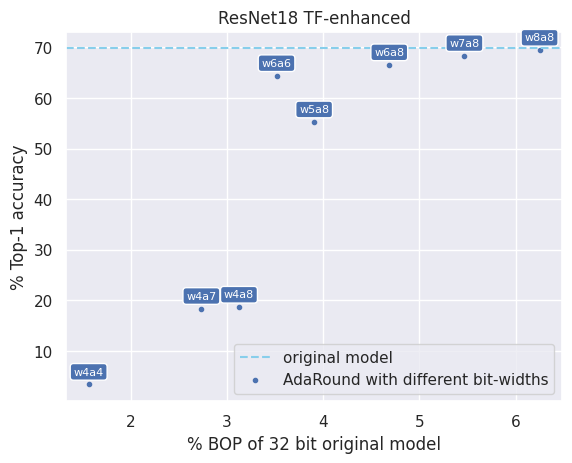

In [17]:
plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')
plt.scatter(aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized*100, marker='.', label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_resnet_simple.param_bw, aimet_resnet_simple.output_bw, aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='bottom', ha='center', fontsize=8, color='white',
             bbox=dict(boxstyle="round"))

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18 TF-enhanced')

# plt.savefig('aimet')
plt.show()

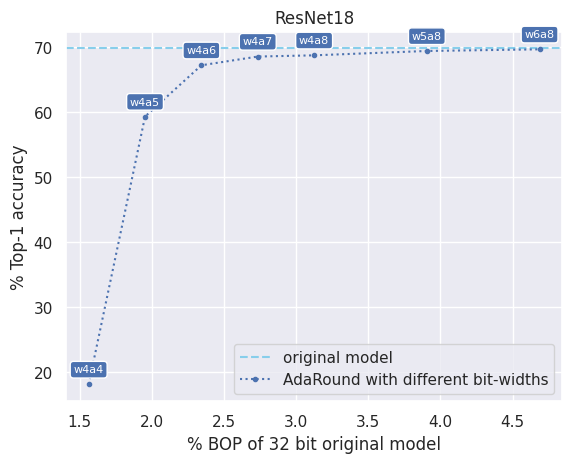

In [49]:
plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')
plt.plot(aimet_resnet.bops, aimet_resnet.acc_quantized*100, 
         marker='.', linestyle='dotted', 
         label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_resnet.param_bw, aimet_resnet.output_bw, aimet_resnet.bops, aimet_resnet.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='bottom', ha='center', fontsize=8, color='white',
             bbox=dict(boxstyle="round"))

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

# plt.savefig('aimet')
plt.show()

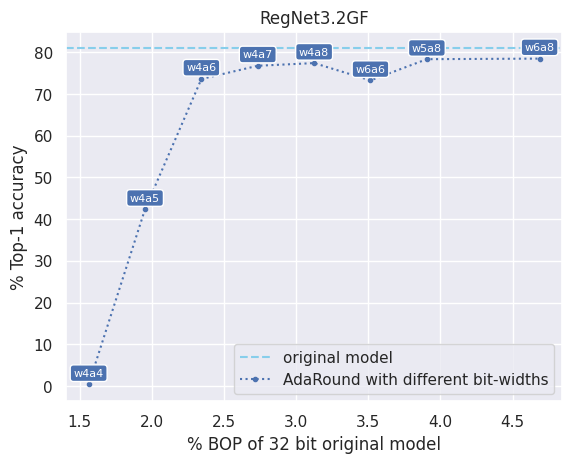

In [39]:
plt.axhline(y=80.87, color='skyblue', linestyle = '--', label='original model')
plt.plot(aimet_regnet.bops, aimet_regnet.acc_quantized*100, 
         marker='.', linestyle='dotted', 
         label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_regnet.param_bw, aimet_regnet.output_bw, aimet_regnet.bops, aimet_regnet.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='bottom', ha='center', fontsize=8, color='white',
             bbox=dict(boxstyle="round"))

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('RegNet3.2GF')

# plt.savefig('aimet')
plt.show()

# custom benchmark

In [49]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'custom_benchmark'
api = wandb.Api()

columns = [
    'model_name',
    'model_path',
    'param_bw',
    'output_bw',
    'observer_samples',
    'param_qscheme',
    'output_qscheme',
    'reduction_rate',
    'bops',
    'macs',
    'acc1_calibrated',
#     'acc5_calibrated',
    'acc1_wquantized(BN32)',
    'acc1_wquantized',
#     'acc5_wquantized',
    'acc1_aquantized',
#     'acc5_aquantized',
    'seed',
    'bops%'
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif col == 'model_name' and run.name.startswith('resnet18'):
                df.loc[i][col] = 'resnet18'
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        if df.loc[i]['model_name'] == 'resnet18':
            df['bops%'] = df.bops/1819040768/32/32*100
        elif df.loc[i]['model_name'] == 'regnet_y_3_2gf':
            df['bops%'] = df.bops/2611094488/32/32*100
#         df['from_rate'] = 'None' in df.model_path
                
        i += 1
        
df.head()

  0%|          | 0/87 [00:00<?, ?it/s]

,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc1_wquantized(BN32),acc1_wquantized,acc1_aquantized,seed,bops%
0,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.5_d=None_i...,8,8,500,tensor_mseminmax_symmetric,histogram,2.5,56239728768,878745762,0.682959,0.681758,0.682979,0.678257,42,3.01926
1,resnet18,checkpoints/resnet18_m=admm_b=8_r=3.0_d=None_i...,8,8,500,tensor_mseminmax_symmetric,histogram,3,48386428992,756037953,0.671915,0.670815,0.671955,0.666273,42,2.59765
2,resnet18,checkpoints/resnet18_m=admm_b=6_r=3.0_d=None_i...,6,8,500,tensor_mseminmax_symmetric,histogram,3,38573997104,756037953,0.667914,0.666473,0.666613,0.662992,42,2.07087
3,resnet18,checkpoints/resnet18_m=admm_b=4_r=1.2_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,1.2,58298653888,1679071974,0.694462,0.693742,0.693262,0.691081,42,3.1298
4,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.0_d...,4,8,500,tensor_minmax,histogram,2,38613937984,1063924602,0.666453,0.0102633,0.37514,0.370178,42,2.07301


In [50]:
custom_benchmark_admm_rate = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.param_qscheme == 'tensor_mseminmax_symmetric'] \
[df.output_qscheme == 'histogram'] \
[df.output_bw == 8] \
[df.model_path.str.contains("None")] \
[df.model_path.str.contains("m=admm")] \
.sort_values('acc1_aquantized').dropna(subset=['acc1_wquantized(BN32)'])
custom_benchmark_admm_rate

/tmp/ipykernel_3582417/990494309.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_benchmark_admm_rate = df \


,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc1_wquantized(BN32),acc1_wquantized,acc1_aquantized,seed,bops%
28,resnet18,checkpoints/resnet18_m=admm_b=4_r=3.0_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,3,28761565216,756037953,0.651528,0.649748,0.649888,0.645667,42,1.54408
25,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.7_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2.7,30945663776,824291033,0.661392,0.659591,0.659231,0.65533,42,1.66134
2,resnet18,checkpoints/resnet18_m=admm_b=6_r=3.0_d=None_i...,6,8,500,tensor_mseminmax_symmetric,histogram,3,38573997104,756037953,0.667914,0.666473,0.666613,0.662992,42,2.07087
24,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.5_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2.5,32688215104,878745762,0.668974,0.666993,0.667734,0.663972,42,1.75489
1,resnet18,checkpoints/resnet18_m=admm_b=8_r=3.0_d=None_i...,8,8,500,tensor_mseminmax_symmetric,histogram,3,48386428992,756037953,0.671915,0.670815,0.671955,0.666273,42,2.59765
13,resnet18,checkpoints/resnet18_m=admm_b=6_r=2.5_d=None_i...,6,8,500,tensor_mseminmax_symmetric,histogram,2.5,44463971936,878745762,0.679297,0.679037,0.679137,0.676036,42,2.38707
29,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.0_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2,38613937984,1063924602,0.682738,0.680738,0.681498,0.677497,42,2.07301
0,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.5_d=None_i...,8,8,500,tensor_mseminmax_symmetric,histogram,2.5,56239728768,878745762,0.682959,0.681758,0.682979,0.678257,42,3.01926
16,resnet18,checkpoints/resnet18_m=admm_b=6_r=2.0_d=None_i...,6,8,500,tensor_mseminmax_symmetric,histogram,2,53352556256,1063924602,0.68872,0.68744,0.68822,0.684079,42,2.86426
15,resnet18,checkpoints/resnet18_m=admm_b=8_r=2.0_d=None_i...,8,8,500,tensor_mseminmax_symmetric,histogram,2,68091174528,1063924602,0.691681,0.689961,0.689401,0.685099,42,3.65551


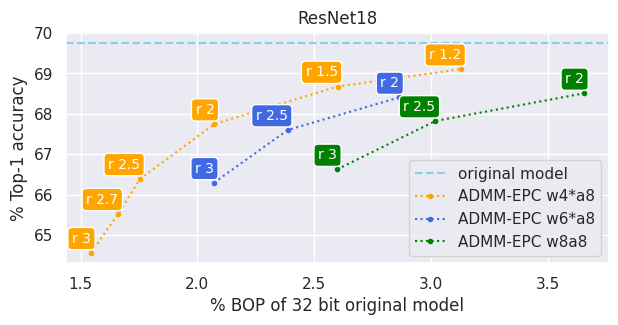

In [7]:
plt.figure(figsize=(7,3))
# plt.figure(figsize=(13,8))

plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')

    
colors = {4: 'orange', 6: 'royalblue', 8: 'green'}
for bw in [4,6,8]:
    data = custom_benchmark_admm_rate[custom_benchmark_admm_rate.param_bw == bw]
    plt.plot(data['bops%'], data.acc1_aquantized*100, 
             marker='.', linestyle='dotted', color = colors[bw],
             label=f"ADMM-EPC w{str(bw) + ('*' if bw < 8 else '')}a8")
    for (wb, ab, bop, acc, rate) in zip(data.param_bw, 
                                        data.output_bw, 
                                        data['bops%'], 
                                        data.acc1_aquantized,
                                        data.reduction_rate):
        plt.text(bop, acc*100 - (-0.35 if bw == 4 else -0.35), f'r {rate}', va='center', ha='right', fontsize=10, color='white',
                 bbox=dict(boxstyle="round", fc = colors[bw]))

plt.legend()
# plt.ylim((1.3, 5))
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

plt.savefig('ablation_admm', bbox_inches='tight')
plt.show()

In [51]:
custom_benchmark_admm_rate = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.param_qscheme == 'tensor_mseminmax_symmetric'] \
[df.output_qscheme == 'histogram'] \
[df.param_bw == 4] \
[df.output_bw == 8] \
[df.model_path.str.contains("None")] \
[df.model_path.str.contains("m=admm")] \
.sort_values('acc1_aquantized', ascending=False).dropna(subset=['acc1_wquantized(BN32)'])
custom_benchmark_admm_rate

/tmp/ipykernel_3582417/2872342353.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_benchmark_admm_rate = df \


,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc1_wquantized(BN32),acc1_wquantized,acc1_aquantized,seed,bops%
3,resnet18,checkpoints/resnet18_m=admm_b=4_r=1.2_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,1.2,58298653888,1679071974,0.694462,0.693742,0.693262,0.691081,42,3.1298
14,resnet18,checkpoints/resnet18_m=admm_b=4_r=1.5_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,1.5,48441421888,1371033474,0.68862,0.68814,0.689701,0.68678,42,2.60061
29,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.0_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2,38613937984,1063924602,0.682738,0.680738,0.681498,0.677497,42,2.07301
24,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.5_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2.5,32688215104,878745762,0.668974,0.666993,0.667734,0.663972,42,1.75489
25,resnet18,checkpoints/resnet18_m=admm_b=4_r=2.7_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,2.7,30945663776,824291033,0.661392,0.659591,0.659231,0.65533,42,1.66134
28,resnet18,checkpoints/resnet18_m=admm_b=4_r=3.0_d=None_i...,4,8,500,tensor_mseminmax_symmetric,histogram,3,28761565216,756037953,0.651528,0.649748,0.649888,0.645667,42,1.54408


In [61]:
for _, row in custom_benchmark_admm_rate[['param_bw', 'output_bw', 'bops%', 'reduction_rate', 'acc1_aquantized']].iterrows():
    print(f"ADMM-EPC & {row.param_bw}/{row.output_bw} & {row.reduction_rate} & {row['bops%']:.2f} & {row.acc1_aquantized*100:.2f} \\\\")

ADMM-EPC & 4/8 & 1.2 & 3.13 & 69.11 \\
ADMM-EPC & 4/8 & 1.5 & 2.60 & 68.68 \\
ADMM-EPC & 4/8 & 2 & 2.07 & 67.75 \\
ADMM-EPC & 4/8 & 2.5 & 1.75 & 66.40 \\
ADMM-EPC & 4/8 & 2.7 & 1.66 & 65.53 \\
ADMM-EPC & 4/8 & 3 & 1.54 & 64.57 \\


In [9]:
# custom_benchmark_admm = df \
# [df.model_name == 'resnet18'] \
# [df.seed == 42] \
# [df.output_qscheme == 'histogram'] \
# [df.output_bw == 8] \
# [df.model_path.str.contains("None")] \
# [df.model_path.str.contains("m=admm")] \
# .sort_values('acc1_aquantized')
# custom_benchmark_admm

In [38]:
custom_benchmark_epc = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.param_qscheme == 'tensor_mseminmax_symmetric'] \
[df.output_qscheme == 'histogram'] \
[df.output_bw == 8] \
[df.model_path.str.contains("d=None")] \
[df.model_path.str.contains("m=parafac-epc")] \
.sort_values('bops%').dropna(subset=['acc1_wquantized(BN32)'])
custom_benchmark_epc

/tmp/ipykernel_3582417/429520488.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_benchmark_epc = df \


,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc1_wquantized(BN32),acc1_wquantized,acc1_aquantized,seed,bops%
23,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=4.0_d...,4,8,500,tensor_mseminmax_symmetric,histogram,4,23864312352,602998801,0.617638,0.0679617,0.427817,0.421635,42,1.28117
18,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=3.0_d...,4,8,500,tensor_mseminmax_symmetric,histogram,3,28761565216,756037953,0.648988,0.161192,0.538712,0.534231,42,1.54408
26,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=4.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,4,31228117808,602998801,0.617638,0.560039,0.597391,0.59323,42,1.6765
30,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.5_d...,4,8,500,tensor_mseminmax_symmetric,histogram,2.5,32688215104,878745762,0.662472,0.1253,0.570403,0.566441,42,1.75489
19,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=3.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,3,38573997104,756037953,0.648988,0.613516,0.638224,0.633003,42,2.07087
27,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=4.0_d...,8,8,500,tensor_mseminmax_symmetric,histogram,4,38591923264,602998801,0.617638,0.613156,0.612536,0.608235,42,2.07183
22,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.0_d...,4,8,500,tensor_mseminmax_symmetric,histogram,2,38613937984,1063924602,0.666453,0.200284,0.600632,0.596891,42,2.07301
31,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.5_d...,6,8,500,tensor_mseminmax_symmetric,histogram,2.5,44463971936,878745762,0.662472,0.627401,0.653789,0.649208,42,2.38707
17,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=3.0_d...,8,8,500,tensor_mseminmax_symmetric,histogram,3,48386428992,756037953,0.648988,0.644986,0.646647,0.641385,42,2.59765
21,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,2,53352556256,1063924602,0.666453,0.634723,0.661232,0.658051,42,2.86426


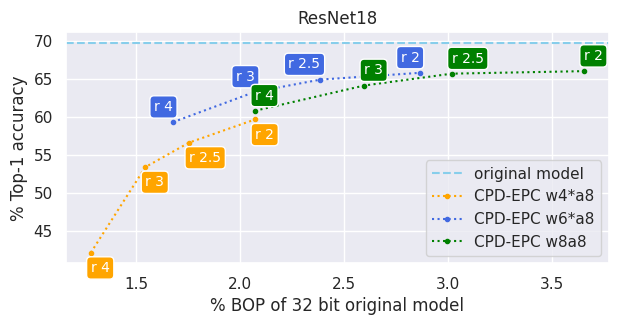

In [11]:
plt.figure(figsize=(7,3))
# plt.figure(figsize=(13,8))

plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')

    
colors = {4: 'orange', 6: 'royalblue', 8: 'green'}
for bw in [4,6,8]:
    data = custom_benchmark_epc[custom_benchmark_epc.param_bw == bw]
    plt.plot(data['bops%'], data.acc1_aquantized*100, 
             marker='.', linestyle='dotted', color = colors[bw],
             label=f"CPD-EPC w{str(bw) + ('*' if bw < 8 else '')}a8")
    for (wb, ab, bop, acc, rate) in zip(data.param_bw, 
                                        data.output_bw, 
                                        data['bops%'], 
                                        data.acc1_aquantized,
                                        data.reduction_rate):
        plt.text(bop, acc*100 - (2 if bw == 4 else -2), f'r {rate}', va='center', ha='left' if wb!=6 else 'right', 
                 fontsize=10, color='white',
                 bbox=dict(boxstyle="round", fc = colors[bw]))

plt.legend()
# plt.xlim((1.3, 5))
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

plt.savefig('ablation_cpd-epc', bbox_inches='tight')
plt.show()

In [41]:
custom_benchmark_epc = df \
[df.model_name == 'resnet18'] \
[df.seed == 42] \
[df.param_qscheme == 'tensor_mseminmax_symmetric'] \
[df.output_qscheme == 'histogram'] \
[df.param_bw == 6] \
[df.output_bw == 8] \
[df.model_path.str.contains("d=None")] \
[df.model_path.str.contains("m=parafac-epc")] \
.sort_values('bops%', ascending=False).dropna(subset=['acc1_wquantized(BN32)'])
custom_benchmark_epc

/tmp/ipykernel_3582417/2019414651.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_benchmark_epc = df \


,model_name,model_path,param_bw,output_bw,observer_samples,param_qscheme,output_qscheme,reduction_rate,bops,macs,acc1_calibrated,acc1_wquantized(BN32),acc1_wquantized,acc1_aquantized,seed,bops%
21,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,2,53352556256,1063924602,0.666453,0.634723,0.661232,0.658051,42,2.86426
31,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=2.5_d...,6,8,500,tensor_mseminmax_symmetric,histogram,2.5,44463971936,878745762,0.662472,0.627401,0.653789,0.649208,42,2.38707
19,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=3.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,3,38573997104,756037953,0.648988,0.613516,0.638224,0.633003,42,2.07087
26,resnet18,checkpoints/resnet18_m=parafac-epc_b=8_r=4.0_d...,6,8,500,tensor_mseminmax_symmetric,histogram,4,31228117808,602998801,0.617638,0.560039,0.597391,0.59323,42,1.6765


In [43]:
for _, row in custom_benchmark_epc[['param_bw', 'output_bw', 'bops%', 'reduction_rate', 'acc1_aquantized']].iterrows():
    print(f"CPD-EPC & {row.param_bw}*/{row.output_bw} & {row.reduction_rate} & {row['bops%']:.2f} & {row.acc1_aquantized*100:.2f} \\\\")

CPD-EPC & 6*/8 & 2 & 2.86 & 65.81 \\
CPD-EPC & 6*/8 & 2.5 & 2.39 & 64.92 \\
CPD-EPC & 6*/8 & 3 & 2.07 & 63.30 \\
CPD-EPC & 6*/8 & 4 & 1.68 & 59.32 \\


# quantization

In [44]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'quantization'
api = wandb.Api()

columns = [
    'method',
    'model_name',
    'param_bw',
    'output_bw',
    'qscheme',
    'bops',
    'adaround',
    'fused',
    'conv1',
    'epc',
    'fold',
    'init',
    'downsample',
    'acc_quantized',
    'reduction_rate',
    'seed',
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        if df.loc[i]['model_name'] == 'resnet18':
            df['bops%'] = df.bops/1819040768/32/32*100
        elif df.loc[i]['model_name'] == 'regnet_y_3_2gf':
            df['bops%'] = df.bops/2611094488/32/32*100
            
        i += 1
        
df.head()

  0%|          | 0/181 [00:00<?, ?it/s]

,method,model_name,param_bw,output_bw,qscheme,bops,adaround,fused,conv1,epc,fold,init,downsample,acc_quantized,reduction_rate,seed,bops%
0,parafac-epc,resnet18,4,8,tensor_mseminmax_symmetric,43714113600,True,False,False,None,True,random,False,0.65681,1.5,42,2.34682
1,parafac-epc,resnet18,4,8,tensor_affine,33886629696,True,False,False,None,True,random,False,0.640265,2,42,1.81922
2,parafac-epc,resnet18,4,8,tensor_affine,28119864384,True,False,False,None,False,random,False,0.634763,2.5,42,1.50963
3,parafac-epc,resnet18,4,8,tensor_affine,27960906816,True,False,False,None,True,random,False,0.631762,2.5,42,1.5011
4,parafac-epc,None,4,8,tensor_affine,30096660800,False,False,False,None,True,random,False,0.0177857,2,42,None


In [45]:
quantization_epc = df \
[df.seed == 42] \
[df.method == 'parafac-epc'] \
[df.adaround == True] \
[df.downsample == False] \
[df.fold == True] \
.sort_values('acc_quantized')
quantization_epc

/tmp/ipykernel_3582417/3964122521.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  quantization_epc = df \


,method,model_name,param_bw,output_bw,qscheme,bops,adaround,fused,conv1,epc,fold,init,downsample,acc_quantized,reduction_rate,seed,bops%
3,parafac-epc,resnet18,4,8,tensor_affine,27960906816,True,False,False,None,True,random,False,0.631762,2.5,42,1.5011
1,parafac-epc,resnet18,4,8,tensor_affine,33886629696,True,False,False,None,True,random,False,0.640265,2,42,1.81922
0,parafac-epc,resnet18,4,8,tensor_mseminmax_symmetric,43714113600,True,False,False,None,True,random,False,0.65681,1.5,42,2.34682


In [48]:
for _, row in quantization_epc[['param_bw', 'output_bw', 'bops%', 'reduction_rate', 'acc_quantized']].iterrows():
    print(f"CPD-EPC + AdaRound & {row.param_bw}*/{row.output_bw} & {row.reduction_rate} & {row['bops%']:.2f} & {row.acc_quantized*100:.2f} \\\\")

CPD-EPC + AdaRound & 4*/8 & 2.5 & 1.50 & 63.18 \\
CPD-EPC + AdaRound & 4*/8 & 2 & 1.82 & 64.03 \\
CPD-EPC + AdaRound & 4*/8 & 1.5 & 2.35 & 65.68 \\


In [15]:
quantization_admm = df \
[df.seed == 42] \
[df.method == 'admm'] \
[df.adaround == True] \
[df.downsample != True] \
[df.conv1 != True] \
[df.fused != True] \
[df.fold != False] \
[df.qscheme == 'tensor_mseminmax_symmetric'] \
.sort_values('acc_quantized')
quantization_admm

/tmp/ipykernel_1295596/1695039261.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  quantization_admm = df \


,method,model_name,param_bw,output_bw,qscheme,bops,adaround,fused,conv1,epc,fold,init,downsample,acc_quantized,reduction_rate,seed,bops%
19,admm,None,6,8,tensor_mseminmax_symmetric,1.67416,True,False,False,None,None,parafac-epc,False,0.640505,3.03,42,None
28,admm,None,4,8,tensor_mseminmax_symmetric,1.62018,True,False,None,None,None,parafac-epc,None,0.650728,2,42,None


# plot

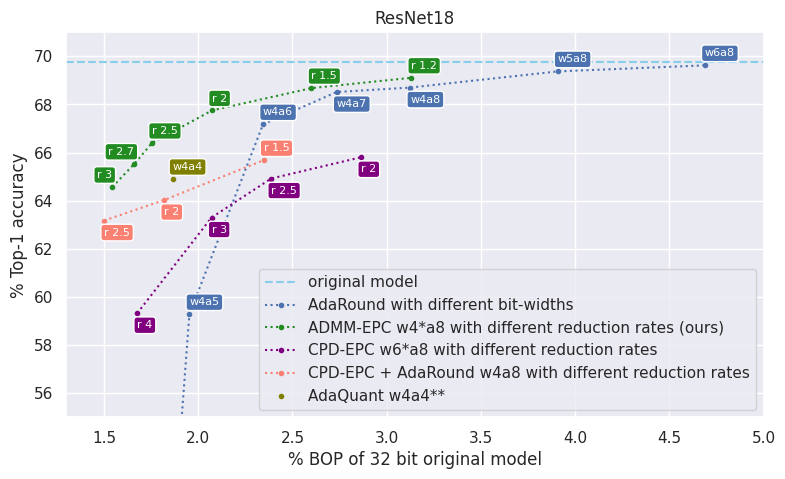

In [25]:
plt.figure(figsize=(9,5))
# plt.figure(figsize=(13,8))
fontsize=8
marg = 0.5

plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')

plt.plot(aimet_resnet.bops, aimet_resnet.acc_quantized*100, marker='.', linestyle='dotted',
         label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_resnet[aimet_resnet.output_bw > 4].param_bw, 
                              aimet_resnet[aimet_resnet.output_bw > 4].output_bw, 
                              aimet_resnet[aimet_resnet.output_bw > 4].bops, 
                              aimet_resnet[aimet_resnet.output_bw > 4].acc_quantized):
    plt.text(bop, acc*100 + (-marg if wb==4 and (ab==7 or ab==8) else marg), 
             f'w{wb}a{ab}', va='center', ha='left', fontsize=fontsize, color='white',
             bbox=dict(boxstyle="round"))
    
# plt.scatter(aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized*100, marker='.', linestyle='dashed', 
#             label='MSE with different bit-widths', color='cornflowerblue')
# for (wb, ab, bop, acc) in zip(aimet_resnet_simple.param_bw, aimet_resnet_simple.output_bw, aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized):
#     plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='cornflowerblue'))
    
# plt.scatter(custom_benchmark_admm['bops%'], custom_benchmark_admm.acc1_aquantized*100, marker='.', 
#             label='ADMM-epc 8bit conv1,fc,downsample', color='darkorange')
# for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm.param_bw, 
#                                     custom_benchmark_admm.output_bw, 
#                                     custom_benchmark_admm['bops%'], 
#                                     custom_benchmark_admm.acc1_aquantized,
#                                     custom_benchmark_admm.reduction_rate):
#     plt.text(bop, acc*100 - 1.6, f'w{wb}a{ab}(x{rate})', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='darkorange'))
    
plt.plot(custom_benchmark_admm_rate['bops%'], custom_benchmark_admm_rate.acc1_aquantized*100, 
         marker='.', linestyle='dotted', color='forestgreen', 
         label='ADMM-EPC w4*a8 with different reduction rates (ours)')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm_rate.param_bw, 
                                    custom_benchmark_admm_rate.output_bw, 
                                    custom_benchmark_admm_rate['bops%'], 
                                    custom_benchmark_admm_rate.acc1_aquantized,
                                    custom_benchmark_admm_rate.reduction_rate):
    plt.text(bop, acc*100 + marg, f'r {rate}', va='center', ha='left' if rate<2.7 else 'right', 
             fontsize=fontsize, color='white',
             bbox=dict(boxstyle="round", fc='forestgreen'))
    
plt.plot(custom_benchmark_epc['bops%'], custom_benchmark_epc.acc1_aquantized*100, 
         marker='.', linestyle='dotted', color='purple',
         label='CPD-EPC w6*a8 with different reduction rates')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_epc.param_bw, 
                                    custom_benchmark_epc.output_bw, 
                                    custom_benchmark_epc['bops%'], 
                                    custom_benchmark_epc.acc1_aquantized,
                                    custom_benchmark_epc.reduction_rate):
    plt.text(bop, acc*100 - marg, f'r {rate}', va='center', ha='left', fontsize=fontsize, color='white',
             bbox=dict(boxstyle="round", fc='purple'))    

# plt.scatter(quantization_admm.bops, quantization_admm.acc_quantized*100, marker='.', label='ADMM-epc + AdaRound', color='pink')
plt.plot(quantization_epc['bops%'], quantization_epc.acc_quantized*100, 
         marker='.', linestyle='dotted', color='salmon',
         label='CPD-EPC + AdaRound w4a8 with different reduction rates')
for (wb, ab, bop, acc, rate) in zip(quantization_epc.param_bw, 
                                    quantization_epc.output_bw, 
                                    quantization_epc['bops%'], 
                                    quantization_epc.acc_quantized,
                                    quantization_epc.reduction_rate):
    plt.text(bop, acc*100 + (marg if rate<2 else -marg), f'r {rate}', va='center', ha='left', fontsize=fontsize, color='white',
             bbox=dict(boxstyle="round", fc='salmon')) 
    
plt.scatter(1.86366, 64.9, marker='.', color='olive',
         label='AdaQuant w4a4**')
plt.text(1.86366, 64.9 + marg, f'w4a4', va='center', ha='left', fontsize=fontsize, color='white',
         bbox=dict(boxstyle="round", fc='olive')) 

plt.legend()
plt.xlim((1.3, 5))
plt.ylim((55, 71))
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

plt.savefig('comparison', dpi=400, bbox_inches='tight')
plt.show()

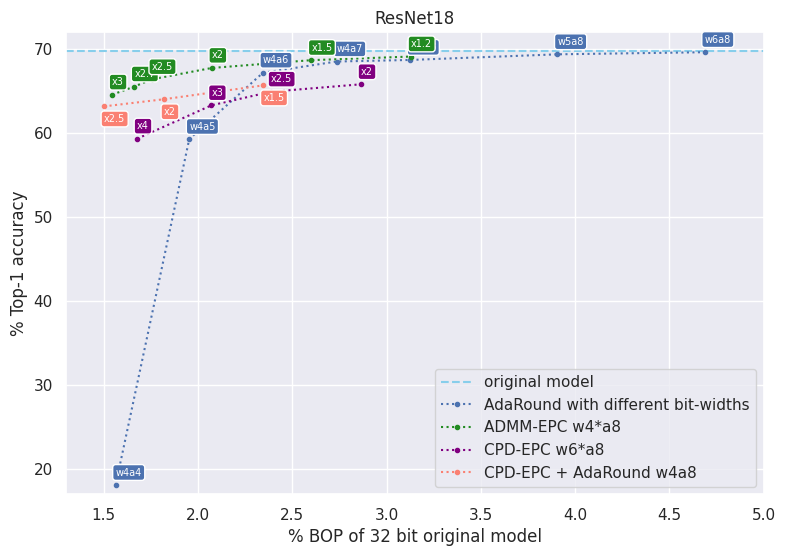

In [33]:
plt.figure(figsize=(9,6))
# plt.figure(figsize=(13,8))

plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')

plt.plot(aimet_resnet.bops, aimet_resnet.acc_quantized*100, marker='.', linestyle='dotted',
         label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_resnet.param_bw, aimet_resnet.output_bw, aimet_resnet.bops, aimet_resnet.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=7, color='white',
             bbox=dict(boxstyle="round"))
    
# plt.scatter(aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized*100, marker='.', linestyle='dashed', 
#             label='MSE with different bit-widths', color='cornflowerblue')
# for (wb, ab, bop, acc) in zip(aimet_resnet_simple.param_bw, aimet_resnet_simple.output_bw, aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized):
#     plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='cornflowerblue'))
    
# plt.scatter(custom_benchmark_admm['bops%'], custom_benchmark_admm.acc1_aquantized*100, marker='.', 
#             label='ADMM-epc 8bit conv1,fc,downsample', color='darkorange')
# for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm.param_bw, 
#                                     custom_benchmark_admm.output_bw, 
#                                     custom_benchmark_admm['bops%'], 
#                                     custom_benchmark_admm.acc1_aquantized,
#                                     custom_benchmark_admm.reduction_rate):
#     plt.text(bop, acc*100 - 1.6, f'w{wb}a{ab}(x{rate})', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='darkorange'))
    
plt.plot(custom_benchmark_admm_rate['bops%'], custom_benchmark_admm_rate.acc1_aquantized*100, 
         marker='.', linestyle='dotted', color='forestgreen', 
         label='ADMM-EPC w4*a8')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm_rate.param_bw, 
                                    custom_benchmark_admm_rate.output_bw, 
                                    custom_benchmark_admm_rate['bops%'], 
                                    custom_benchmark_admm_rate.acc1_aquantized,
                                    custom_benchmark_admm_rate.reduction_rate):
    plt.text(bop, acc*100 + 1.5, f'x{rate}', va='center', ha='left', fontsize=7, color='white',
             bbox=dict(boxstyle="round", fc='forestgreen'))
    
plt.plot(custom_benchmark_epc['bops%'], custom_benchmark_epc.acc1_aquantized*100, 
         marker='.', linestyle='dotted', color='purple',
         label='CPD-EPC w6*a8')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_epc.param_bw, 
                                    custom_benchmark_epc.output_bw, 
                                    custom_benchmark_epc['bops%'], 
                                    custom_benchmark_epc.acc1_aquantized,
                                    custom_benchmark_epc.reduction_rate):
    plt.text(bop, acc*100 + 1.5, f'x{rate}', va='center', ha='left', fontsize=7, color='white',
             bbox=dict(boxstyle="round", fc='purple'))    

# plt.scatter(quantization_admm.bops, quantization_admm.acc_quantized*100, marker='.', label='ADMM-epc + AdaRound', color='pink')
plt.plot(quantization_epc['bops%'], quantization_epc.acc_quantized*100, 
         marker='.', linestyle='dotted', color='salmon',
         label='CPD-EPC + AdaRound w4a8')
for (wb, ab, bop, acc, rate) in zip(quantization_epc.param_bw, 
                                    quantization_epc.output_bw, 
                                    quantization_epc['bops%'], 
                                    quantization_epc.acc_quantized,
                                    quantization_epc.reduction_rate):
    plt.text(bop, acc*100 - 1.5, f'x{rate}', va='center', ha='left', fontsize=7, color='white',
             bbox=dict(boxstyle="round", fc='salmon'))  

plt.legend()
plt.xlim((1.3, 5))
plt.ylim((17, 72))
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

plt.savefig('comparison')
plt.show()

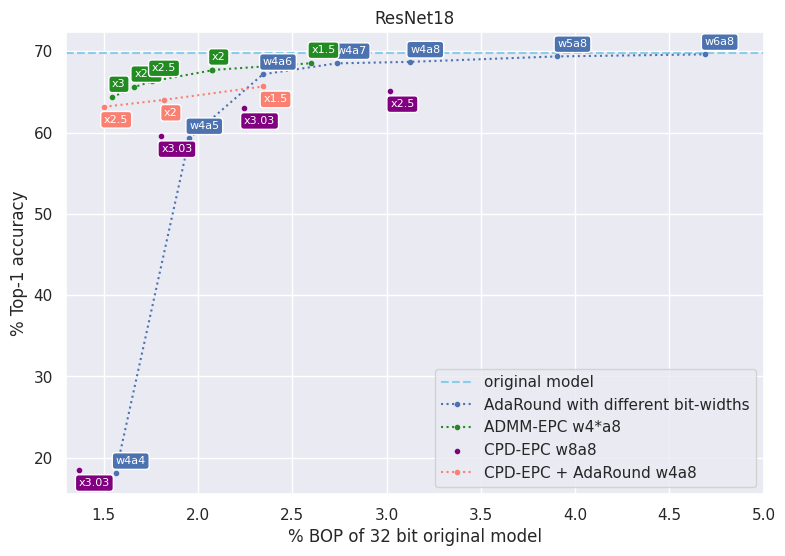

In [53]:
plt.figure(figsize=(9,6))
# plt.figure(figsize=(13,8))

plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')

plt.plot(aimet_resnet.bops, aimet_resnet.acc_quantized*100, marker='.', linestyle='dotted',
         label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_resnet.param_bw, aimet_resnet.output_bw, aimet_resnet.bops, aimet_resnet.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=8, color='white',
             bbox=dict(boxstyle="round"))
    
# plt.scatter(aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized*100, marker='.', linestyle='dashed', 
#             label='MSE with different bit-widths', color='cornflowerblue')
# for (wb, ab, bop, acc) in zip(aimet_resnet_simple.param_bw, aimet_resnet_simple.output_bw, aimet_resnet_simple.bops, aimet_resnet_simple.acc_quantized):
#     plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='cornflowerblue'))
    
# plt.scatter(custom_benchmark_admm['bops%'], custom_benchmark_admm.acc1_aquantized*100, marker='.', 
#             label='ADMM-epc 8bit conv1,fc,downsample', color='darkorange')
# for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm.param_bw, 
#                                     custom_benchmark_admm.output_bw, 
#                                     custom_benchmark_admm['bops%'], 
#                                     custom_benchmark_admm.acc1_aquantized,
#                                     custom_benchmark_admm.reduction_rate):
#     plt.text(bop, acc*100 - 1.6, f'w{wb}a{ab}(x{rate})', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='darkorange'))
    
plt.plot(custom_benchmark_admm_rate['bops%'], custom_benchmark_admm_rate.acc1_aquantized*100, 
         marker='.', linestyle='dotted', color='forestgreen', 
         label='ADMM-EPC w4*a8')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm_rate.param_bw, 
                                    custom_benchmark_admm_rate.output_bw, 
                                    custom_benchmark_admm_rate['bops%'], 
                                    custom_benchmark_admm_rate.acc1_aquantized,
                                    custom_benchmark_admm_rate.reduction_rate):
    plt.text(bop, acc*100 + 1.6, f'x{rate}', va='center', ha='left', fontsize=8, color='white',
             bbox=dict(boxstyle="round", fc='forestgreen'))
    
plt.scatter(custom_benchmark_epc['bops%'], custom_benchmark_epc.acc1_aquantized*100, marker='.', 
            label='CPD-EPC w8a8', color='purple')
for (wb, ab, bop, acc, rate) in zip(custom_benchmark_epc.param_bw, 
                                    custom_benchmark_epc.output_bw, 
                                    custom_benchmark_epc['bops%'], 
                                    custom_benchmark_epc.acc1_aquantized,
                                    custom_benchmark_epc.reduction_rate):
    plt.text(bop, acc*100 - 1.6, f'x{rate}', va='center', ha='left', fontsize=8, color='white',
             bbox=dict(boxstyle="round", fc='purple'))    

# plt.scatter(quantization_admm.bops, quantization_admm.acc_quantized*100, marker='.', label='ADMM-epc + AdaRound', color='pink')
plt.plot(quantization_epc['bops%'], quantization_epc.acc_quantized*100, 
         marker='.', linestyle='dotted', color='salmon',
         label='CPD-EPC + AdaRound w4a8')
for (wb, ab, bop, acc, rate) in zip(quantization_epc.param_bw, 
                                    quantization_epc.output_bw, 
                                    quantization_epc['bops%'], 
                                    quantization_epc.acc_quantized,
                                    quantization_epc.reduction_rate):
    plt.text(bop, acc*100 - 1.6, f'x{rate}', va='center', ha='left', fontsize=8, color='white',
             bbox=dict(boxstyle="round", fc='salmon'))  

plt.legend()
plt.xlim((1.3, 5))
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('ResNet18')

# plt.savefig('comparison')
plt.show()

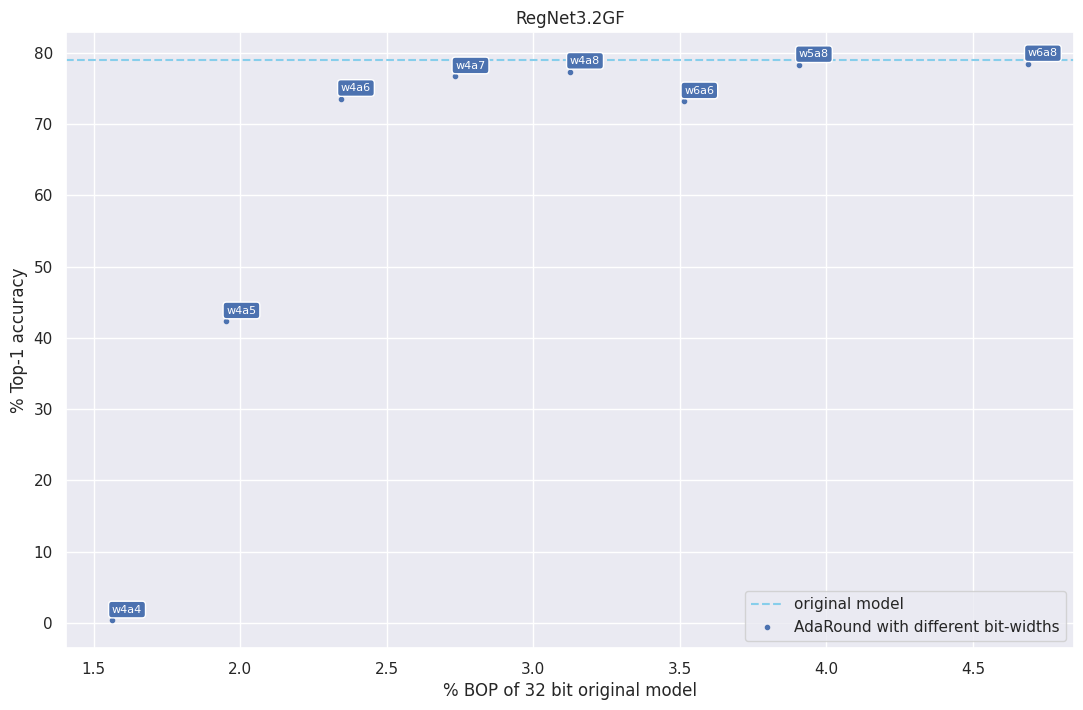

In [80]:
# plt.figure(figsize=(9,6))
plt.figure(figsize=(13,8))

plt.axhline(y=78.948, color='skyblue', linestyle = '--', label='original model')

plt.scatter(aimet_regnet.bops, aimet_regnet.acc_quantized*100, marker='.', label='AdaRound with different bit-widths')
for (wb, ab, bop, acc) in zip(aimet_regnet.param_bw, aimet_regnet.output_bw, aimet_regnet.bops, aimet_regnet.acc_quantized):
    plt.text(bop, acc*100 + 1.5, f'w{wb}a{ab}', va='center', ha='left', fontsize=8, color='white',
             bbox=dict(boxstyle="round"))
    
# plt.scatter(custom_benchmark_admm['bops%'], custom_benchmark_admm.acc1_aquantized*100, marker='.', 
#             label='ADMM-epc 8bit conv1,fc,downsample', color='darkorange')
# for (wb, ab, bop, acc, rate) in zip(custom_benchmark_admm.param_bw, 
#                                     custom_benchmark_admm.output_bw, 
#                                     custom_benchmark_admm['bops%'], 
#                                     custom_benchmark_admm.acc1_aquantized,
#                                     custom_benchmark_admm.reduction_rate):
#     plt.text(bop, acc*100 - 1.6, f'w{wb}a{ab}(x{rate})', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='darkorange'))
    
# plt.scatter(custom_benchmark_epc['bops%'], custom_benchmark_epc.acc1_aquantized*100, marker='.', 
#             label='Parafac-epc 8bit conv1,fc,downsample', color='forestgreen')
# for (wb, ab, bop, acc, rate) in zip(custom_benchmark_epc.param_bw, 
#                                     custom_benchmark_epc.output_bw, 
#                                     custom_benchmark_epc['bops%'], 
#                                     custom_benchmark_epc.acc1_aquantized,
#                                     custom_benchmark_epc.reduction_rate):
#     plt.text(bop, acc*100 - 1.6, f'w{wb}a{ab}(x{rate})', va='center', ha='left', fontsize=8, color='white',
#              bbox=dict(boxstyle="round", fc='forestgreen'))    

# plt.scatter(quantization_admm.bops, quantization_admm.acc_quantized*100, marker='.', label='ADMM-epc + AdaRound', color='pink')
# plt.scatter(quantization_epc.bops, quantization_epc.acc_quantized*100, marker='.', label='Parafac-epc + AdaRound', color='cyan')


plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('RegNet3.2GF')

# plt.savefig('comparison')
plt.show()

In [99]:
aimet_regnet.bops, aimet_regnet.acc_quantized*100

(5      1.5625
 2    1.953125
 3    3.515625
 6     2.34375
 4    2.734375
 7       3.125
 0     3.90625
 1      4.6875
 Name: bops, dtype: object,
 5     0.368118
 2    42.341549
 3    73.213428
 6    73.551536
 4    76.720551
 7    77.362756
 0    78.299056
 1      78.4371
 Name: acc_quantized, dtype: object)

In [29]:
quantization_epc.acc_quantized, quantization_epc.bops

(4    0.605374
 6    0.626701
 5    0.649868
 Name: acc_quantized, dtype: object,
 4    1.116108
 6    1.674162
 5    1.620181
 Name: bops, dtype: object)

In [13]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'quantization'
api = wandb.Api()

columns = [
    'method',
    'param_bw',
    'output_bw',
    'adaround_samples',
    'adaround_iterations',
    'adaround',
    'calibration_samples',
    'decomp',
    'eps',
    'reduction_rate',
    'bits',
    'qscheme',
    'init',
    'no_layer1',
    'seed',
    'macs_reduced',
    'bops',
    'acc_quantized',
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
                
        i += 1
        
df.head()

  0%|          | 0/155 [00:00<?, ?it/s]

,method,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,calibration_samples,decomp,eps,reduction_rate,bits,qscheme,init,no_layer1,seed,macs_reduced,bops,acc_quantized
0,admm,4,8,2048,20000,False,4096,cp3-epc-pars,None,2,8,tensor_minmax,parafac-epc,False,42,0.518458,1.620181,0.002961
1,admm,4,8,2048,20000,False,4096,cp3-epc-pars,None,2,4,tensor_minmax,parafac-epc,False,42,0.518458,1.620181,0.001
2,admm,4,8,2048,20000,True,4096,cp3-epc-pars,None,2,4,tensor_mseminmax_symmetric,parafac-epc,False,42,0.518458,1.620181,0.650728
3,admm,4,8,2048,20000,True,4096,cp3-epc-pars,None,2,4,tensor_mseminmax_symmetric,parafac-epc,False,42,0.518458,1.620181,0.644066
4,admm,4,8,2048,20000,False,4096,cp3-epc-pars,None,2,4,tensor_mseminmax_symmetric,parafac-epc,False,42,0.518458,1.620181,0.153889


In [14]:
admm_quantization = df \
[df.method=='admm'] \
[df.qscheme=='tensor_affine'] \
[df.init=='parafac-epc'] \
[df.no_layer1==True] \
[df.adaround==True] \
[df.eps==0.0005] \
[df.bits==8] \
.sort_values('acc_quantized')
admm_quantization

/tmp/ipykernel_1431274/2535469597.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  admm_quantization = df \


,method,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,calibration_samples,decomp,eps,reduction_rate,bits,qscheme,init,no_layer1,seed,macs_reduced,bops,acc_quantized
48,admm,4,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,parafac-epc,True,42,0.56057,1.751782,0.665313
47,admm,6,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,parafac-epc,True,42,0.56057,2.627673,0.682198
46,admm,8,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,parafac-epc,True,42,0.56057,3.503565,0.684119


In [15]:
epc_quantization = df \
[df.method=='parafac-epc'] \
[df.qscheme=='tensor_affine'] \
[df.init=='random'] \
[df.no_layer1==True] \
[df.adaround==True] \
[df.eps==0.0005] \
[df.bits==8] \
.sort_values('acc_quantized')
epc_quantization

/tmp/ipykernel_1431274/427873421.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  epc_quantization = df \


,method,param_bw,output_bw,adaround_samples,adaround_iterations,adaround,calibration_samples,decomp,eps,reduction_rate,bits,qscheme,init,no_layer1,seed,macs_reduced,bops,acc_quantized
50,parafac-epc,4,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,random,True,42,0.56057,1.751782,0.645206
51,parafac-epc,6,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,random,True,42,0.56057,2.627673,0.662812
49,parafac-epc,8,8,2048,20000,True,4096,cp3-epc,0.0005,None,8,tensor_affine,random,True,42,0.56057,3.503565,0.665753


In [16]:
plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')
# plt.scatter([1.56, 3.13, 6.25], [5.78, 18.87, 69.76], marker='o', label='Quantization')
plt.plot(aimet_benchmark.bops, aimet_benchmark.acc_quantized*100, marker='.', linestyle='', label='AdaRound with different bit-widths')
plt.plot(admm_quantization.bops, admm_quantization.acc_quantized*100, marker='.', linestyle='', label='ADMM-epc50it tensor affine + AdaRound')
plt.plot(epc_quantization.bops, epc_quantization.acc_quantized*100, marker='.', linestyle='', label='Parafac-epc5000it + AdaRound')
# plt.scatter([1.752, 2.628, 3.504], [66.51, 68.3, 68.54], marker='.', label='ADMM-epc5000it tensor affine + AdaRound')

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('Comparison to baseline methods')

plt.savefig('comparison')
plt.show()

KeyboardInterrupt: 

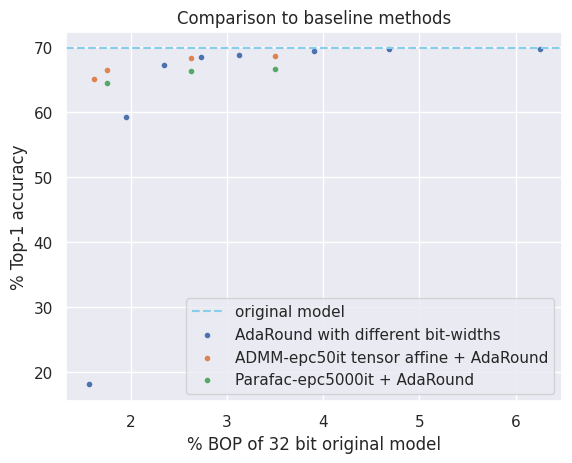

In [22]:
plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')
# plt.scatter([1.56, 3.13, 6.25], [5.78, 18.87, 69.76], marker='o', label='Quantization')
# plt.scatter([1.56, 1.95, 2.34, 3.13, 4.69, 6.25], [24.535, 59.58, 67.01, 68.28, 69.52, 69.7], marker='.', label='AdaRound with different bit-widths')
plt.scatter(aimet_benchmark.bops, aimet_benchmark.acc_quantized*100, marker='.', label='AdaRound with different bit-widths')
plt.scatter([1.62, 1.752, 2.628, 3.504], [65.07, 66.48, 68.22, 68.54], marker='.', label='ADMM-epc50it tensor affine + AdaRound')
plt.scatter([1.752, 2.628, 3.504], [64.52, 66.28, 66.58], marker='.', label='Parafac-epc5000it + AdaRound')
# plt.scatter([1.752, 2.628, 3.504], [66.51, 68.3, 68.54], marker='.', label='ADMM-epc5000it tensor affine + AdaRound')

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('Comparison to baseline methods')

plt.savefig('comparison')
plt.show()

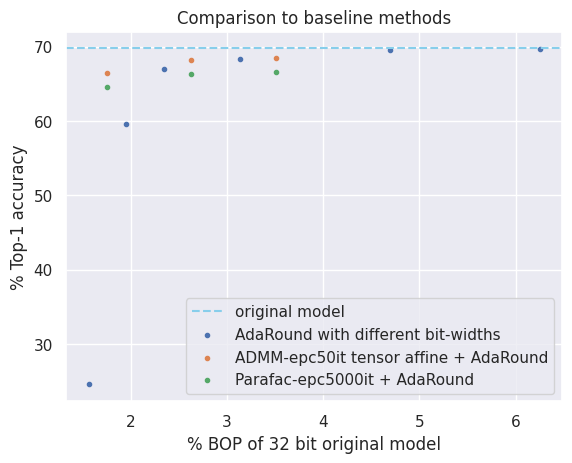

In [19]:
plt.axhline(y=69.76, color='skyblue', linestyle = '--', label='original model')
# plt.scatter([1.56, 3.13, 6.25], [5.78, 18.87, 69.76], marker='o', label='Quantization')
plt.scatter([1.56, 1.95, 2.34, 3.13, 4.69, 6.25], [24.535, 59.58, 67.01, 68.28, 69.52, 69.7], marker='.', label='AdaRound with different bit-widths')
# plt.scatter(aimet_benchmark.bops, aimet_benchmark.acc_quantized*100, marker='.', label='AdaRound with different bit-widths')
plt.scatter([1.752, 2.628, 3.504], [66.48, 68.22, 68.54], marker='.', label='ADMM-epc50it tensor affine + AdaRound')
plt.scatter([1.752, 2.628, 3.504], [64.52, 66.28, 66.58], marker='.', label='Parafac-epc5000it + AdaRound')
# plt.scatter([1.752, 2.628, 3.504], [66.51, 68.3, 68.54], marker='.', label='ADMM-epc5000it tensor affine + AdaRound')

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('Comparison to baseline methods')

plt.savefig('comparison')
plt.show()